# test2p3.ipynb

A notebook to run variations of spinal_test_2 part 3.

The task is the same as in spinal_test1.ipynb, but the am_pm_oscillator model is used.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

# PART 3
Closed loop test of the `am_pm_oscillator` model for a multidimensional plant.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
def haar_matrix(dim):
    """ Returns an array with the normalized (2**dim x 2**dim) Haar matrix.
    
        Args:
            dim: an integer.
        Returns:
            A 2D numpy array of shape (2**dim, 2**dim), where each row is a
            Haar vector of norm 1.
    """
    # Obtain the matrix using the iterative procedure with Kronecker products
    h0 = np.array([1., 1.])
    h1 = np.array([1., -1.])
    haar = np.concatenate(([h0], [h1]))
    for d in range(1,dim):
        haar = np.concatenate((np.kron(haar, h0), 
                               np.kron(np.identity(2**d), h1)), axis=0)
    # Normalize the rows of the Haar matrix
    for idx, row in enumerate(haar):
        haar[idx, :] = row / np.linalg.norm(row)
    return haar

In [3]:
###################
#  Configuration  #
##################
N = 2 # size of each population
t_pres = 50. # duration of each pattern presentation
M__P_type = 'identity' # type of M__P connections. See M__P_mats below
M_type = "am2D" # "am_pm", "am", "am2D", "am_pulse"
SPF__M_syn_type = synapse_types.rga # rga, normal_rga, rga_21, meca_hebb
track_SPF__M_w = True # whether to track SPF__M weight for 1 M(E|I) unit
om_var = 2. # increases omega frequency heterogeneity

In [4]:
#--------------------------------------------------------------
M__P_mats = {'identity' : 1.*np.eye(N),
             'haar' : haar_matrix(int(np.round(np.log(N)/np.log(2.)))),
             'overcomplete2' : np.random.random((N, 3*N))}
if N > 1:
    M__P_mats['overcomplete'] = np.concatenate((M__P_mats['identity'], M__P_mats['haar']), axis=1)
norms = np.linalg.norm(M__P_mats['overcomplete2'], axis=0)
M__P_mats['overcomplete2'] = M__P_mats['overcomplete2']/norms
W = M__P_mats[M__P_type]
M_N = W.shape[1]


des_pat = np.zeros(N) # desired pattern in SP
des_pats = np.random.random((2000, N)) # many desired patterns for SP
des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand(N)-0.5))

net_params = {'min_delay' : 0.001,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0. * randz(),
             'slope' : 1. * randz(),
             'init_val' : 0.2 * randz(),
             'tau' : 0.05 }#* randz() }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.4 * randz(), # 0.5 originally
              'slope' : 4. * randz(),  # 4. originally
              'delay' : 0.43,
              'init_val' : 0.3 * randz(),
              'tau_fast': 0.01, # 0.005
              'tau_mid': 0.2,  # 0.05
              'tau_slow' : 10., # 5
              'tau' : 0.05, #* randz(),
              'des_out_w_abs_sum' : 1. }
SPF2_params = SPF1_params
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }#* randz() }

if M_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    M_syn_type = unit_types.am_pm_oscillator
elif M_type == "am2D":
    init_base = np.array([0.5, 0.5])
    M_syn_type = unit_types.am_oscillator2D
elif M_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    M_syn_type = unit_types.am_pulse
elif M_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    M_syn_type = unit_types.am_oscillator
M_params = {'type' : M_syn_type,
            'integ_meth' : 'odeint',
            'tau_u' : 0.1,
            'tau_c' : .1, # originally 0.2
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
            'inp_deriv_ports' : [[0,1]]*M_N if SPF__M_syn_type==synapse_types.meca_hebb else [[0,1]]*M_N,
            'del_inp_ports' : [[0,1]]*M_N if SPF__M_syn_type==synapse_types.meca_hebb else [[0,1]]*M_N,
            'multidim' : True,
            'F' : 'zero',
            'n_ports' : 2,
            'omega' : 2.*np.pi, #2*
            'custom_inp_del' : 200,
            'tau_fast': 0.005,
            'tau_mid' : 0.05,
            'tau_slow' : 1.,
            'delay' : 0.43,
            'A' : 1.,
            'mu' : 0.,
            'sigma' : 0., #0.5,
            'extra_requirements' : ['lpf_fast', 'lpf_mid']}

#-----------------------------------------------------------------
# Connection parameters
#-----------------------------------------------------------------

# connect ME/MI to P
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static_l1_normal,
             'w_sum' : 2.,
             'tau_norml' : 5.,
             'init_w' : W.flatten() }
MI__P_conn = ME__P_conn
MI__P_syn = {'type': synapse_types.static_l1_normal,
             'w_sum' : 2.,
             'tau_norml' : 5.,
             'init_w' : -W.flatten() }
# lateral connections in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : -0.02/N }
ME__MI_conn = {'rule': 'one_to_one',
               'delay' : 0.02 }
ME__MI_syn = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -0.5 } # -0.5 }
MI__ME_conn = ME__MI_conn
MI__ME_syn = ME__MI_syn
MI__MI_conn = ME__ME_conn
MI__MI_syn = ME__ME_syn
# From P to SF
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# SF__SPF
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = SF__SPF1_conn
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = SP__SPF1_conn
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {'type' : SPF__M_syn_type,
                'lrate': 50., #40.,
                #'post_delay': del_steps,
                'inp_ports': 0,
                'max_w' : 2.,
                'min_w' : 0.,
                'sig1' : .2,
                'sig2' : .2,
                #'latency' : None, # deprecated
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn

#---------------------------------------------------------------------
# Change default parameters
#---------------------------------------------------------------------
SPF1_params['tau_slow'] = 10. #20.
SPF2_params['tau_slow'] = 10. #20.
M_params['tau_slow'] = 10.
M_params['omega'] = 2.*np.pi
M_params['A'] = 0.0 #.8
SPF1__ME_syn ['lrate'] = 150.
SPF2__ME_syn ['lrate'] = SPF1__ME_syn ['lrate']
SPF1__MI_syn ['lrate'] = SPF1__ME_syn ['lrate']
SPF2__MI_syn ['lrate'] = SPF1__ME_syn ['lrate']
M_params['integ_meth'] = 'euler_maru'
M_params['sigma'] = 0.3


---

In [5]:
# creating units
net = network(net_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base angular frequency (rad/s)
            r : amplitude of noise
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w + r*(np.random.random(n) - 0.5)
    #ws = ws / M_params['tau_t'] # angular frequencies
    mp_del = np.arctan(P_params['tau']*ws)/ws
    psf_del = np.arctan(SF_params['tau']*ws)/ws
    sfspf_del = np.arctan(SPF1_params['tau']*ws)/ws
    spfm_del1 = np.arctan(M_params['tau_c']*ws)/ws
    spfm_del2 = np.arctan(M_params['tau_u']*ws)/ws
    d1 = mp_del + psf_del + sfspf_del + 4.*0.02
    #if SPF__M_syn_type == synapse_types.meca_hebb:
    #    d1 += spfm_del1
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

omegasE, del_stepsE = create_freqs_steps(M_N, M_params['omega'], om_var)
omegasI, del_stepsI = create_freqs_steps(M_N, M_params['omega'], om_var)
lE_steps = [0]*M_N # default value for synapses other than meca_hebb
lI_steps = [0]*M_N

if SPF__M_syn_type == synapse_types.meca_hebb: # adding extra latency
    latsE = np.arctan(M_params['tau_c']*np.array(omegasE)) / np.array(omegasE)
    latsI = np.arctan(M_params['tau_c']*np.array(omegasI)) / np.array(omegasI)
    lE_steps = np.ceil(latsE/net_params['min_delay']).astype(int)
    lI_steps = np.ceil(latsI/net_params['min_delay']).astype(int)
    
M_params['omega'] = omegasE
M_params['inp_del_steps'] = del_stepsE
M_params['custom_inp_del'] = [dsE+lEs for dsE,lEs in zip(del_stepsE,lE_steps)]
ME = net.create(M_N, M_params)

M_params['omega'] = omegasI
M_params['inp_del_steps'] = del_stepsI
M_params['custom_inp_del'] = [dsI+lIs for dsI,lIs in zip(del_stepsI,lI_steps)]
MI = net.create(M_N, M_params)
    
# set the pattern in SP
def make_fun(idx):
    #return lambda t: des_pat[idx]
    return lambda t: des_pats[int(round(t/t_pres)),idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)
# extra ME-->MI connections to promote desynchronization
# ME__MI_connX = {'rule': 'all_to_all',
#                'delay' : 0.02 }
# ME__MI_synX = {'type' : synapse_types.static,
#               'inp_ports': 1,
#               'init_w' : -.2/N }#-0.1 }
# # this is to avoid duplicate connections
# for idx, me in enumerate(ME):
#     MI_reduced = MI[:idx] + MI[idx+1:]
#     net.connect([me], MI_reduced, ME__MI_connX, ME__MI_synX)
    
# tracking state variables of the am_pm_oscillator
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
def create_state_track(uid, var_id):
    return lambda t: net.units[uid].buffer[var_id,-1]
if M_type == "am":
    n_track = 3
elif M_type in ["am2D", "am_pulse"]:
    n_track = 2
elif M_type == "am_pm":
    n_track = 4
M_track = net.create(n_track, track_params)
for var in range(n_track):
    net.units[M_track[var]].set_function(create_state_track(ME[0],var))
    
if track_SPF__M_w:
    # tracking SPF__ME weights
    SPF__M_track = net.create(2*N, track_params)
    SPF__M_syns = [syn for syn in net.syns[ME[0]] if syn.port == SPF1__ME_syn['inp_ports']]
    def SPF__M_fun(idx):
        """ Creates a function to track a weight from SPF to ME. """
        return lambda t: SPF__M_syns[idx].w
    for idx in range(len(SPF1+SPF2)):
        net.units[SPF__M_track[idx]].set_function(SPF__M_fun(idx))

In [6]:
sim_time = 200.
start_time = time.time()
times, data, _  = net.flat_run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 269.0552132129669 seconds


In [30]:
# reducing the scope of the plots
data_back = data
times_back = times

init_t = 73. # initial second of the reduced plot
final_t = 77. # final second of the reduced plot
t_steps = int(1./net_params['min_delay'])
first_idx = int(init_t * t_steps)
second_idx = int(final_t * t_steps)
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]

In [28]:
# recover the data
data = data_back
times = times_back

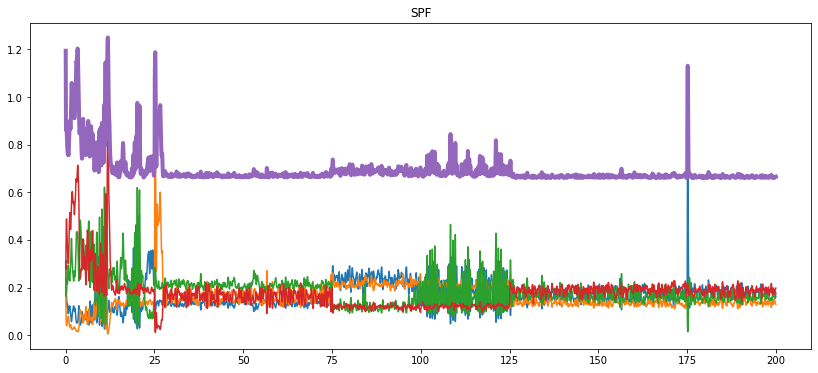

[0.17746207 0.12985685 0.1605905  0.19774632]


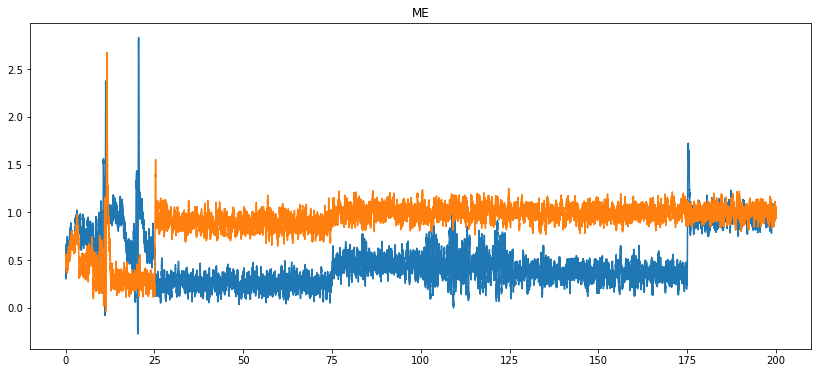

[0.9649707  1.00615154]


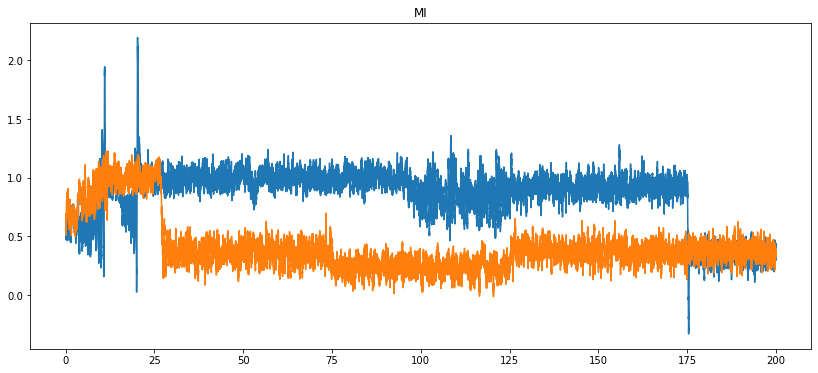

[0.42136465 0.37067331]


In [7]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.plot(times, np.sum(SPF_data, axis=0), linewidth=4)
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# M
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])


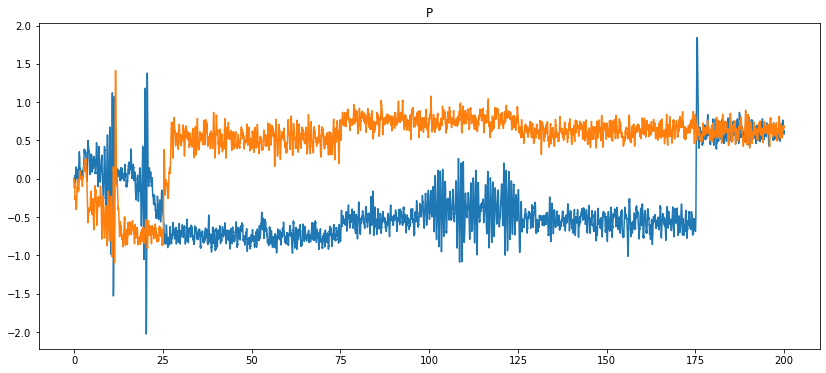

[0.59034689 0.6730951 ]


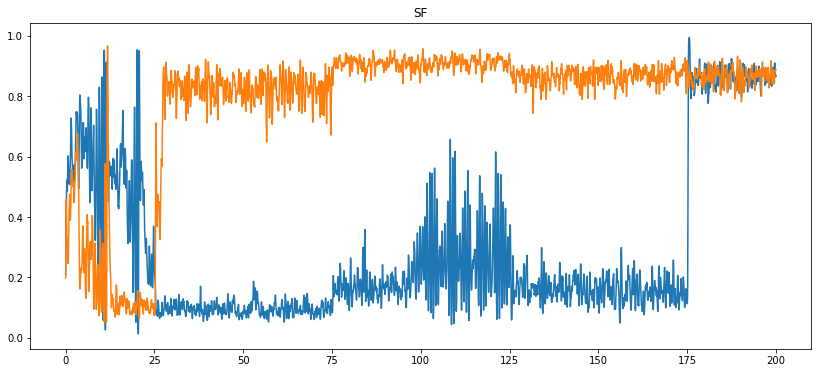

[0.86868004 0.88736099]
[0.88181525 0.82573075]


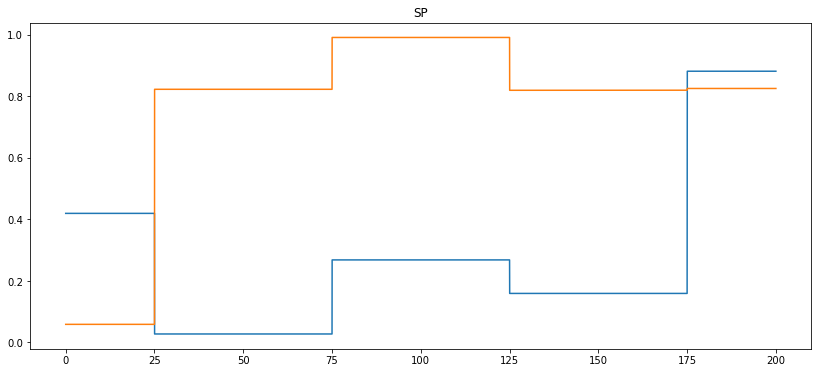

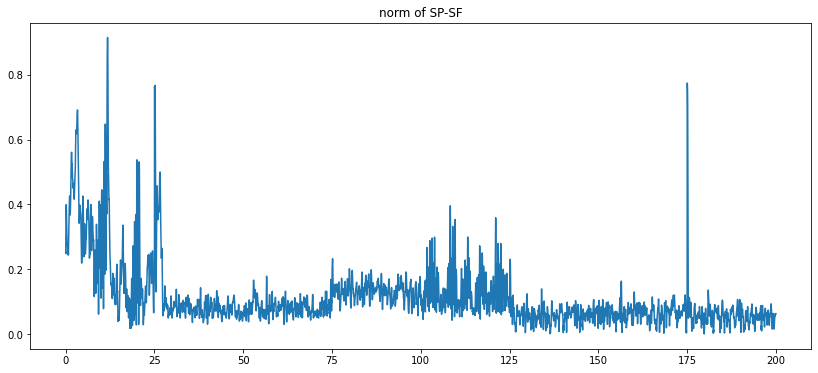

In [8]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


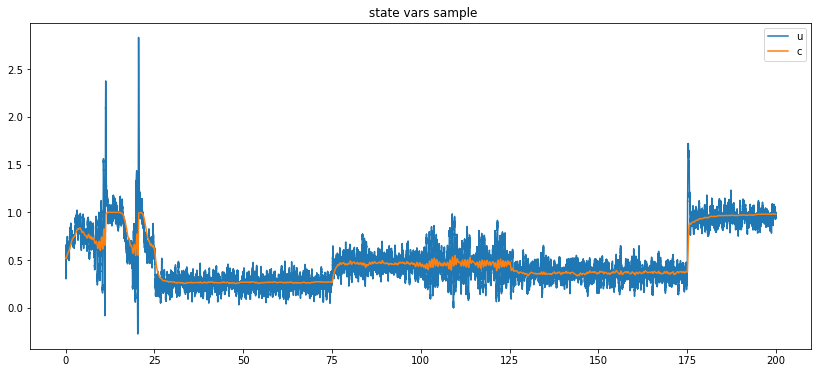

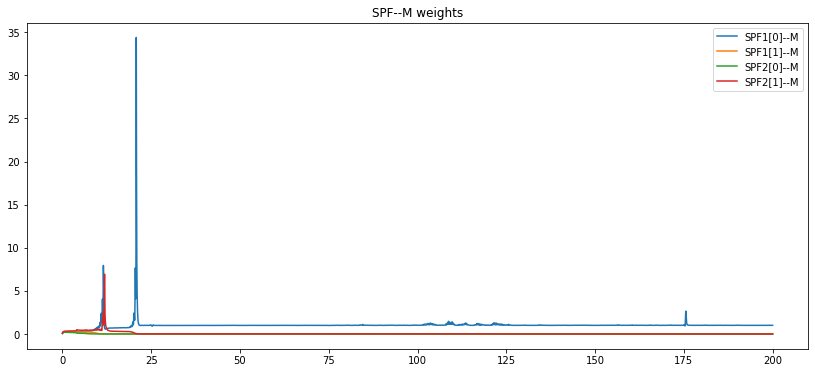

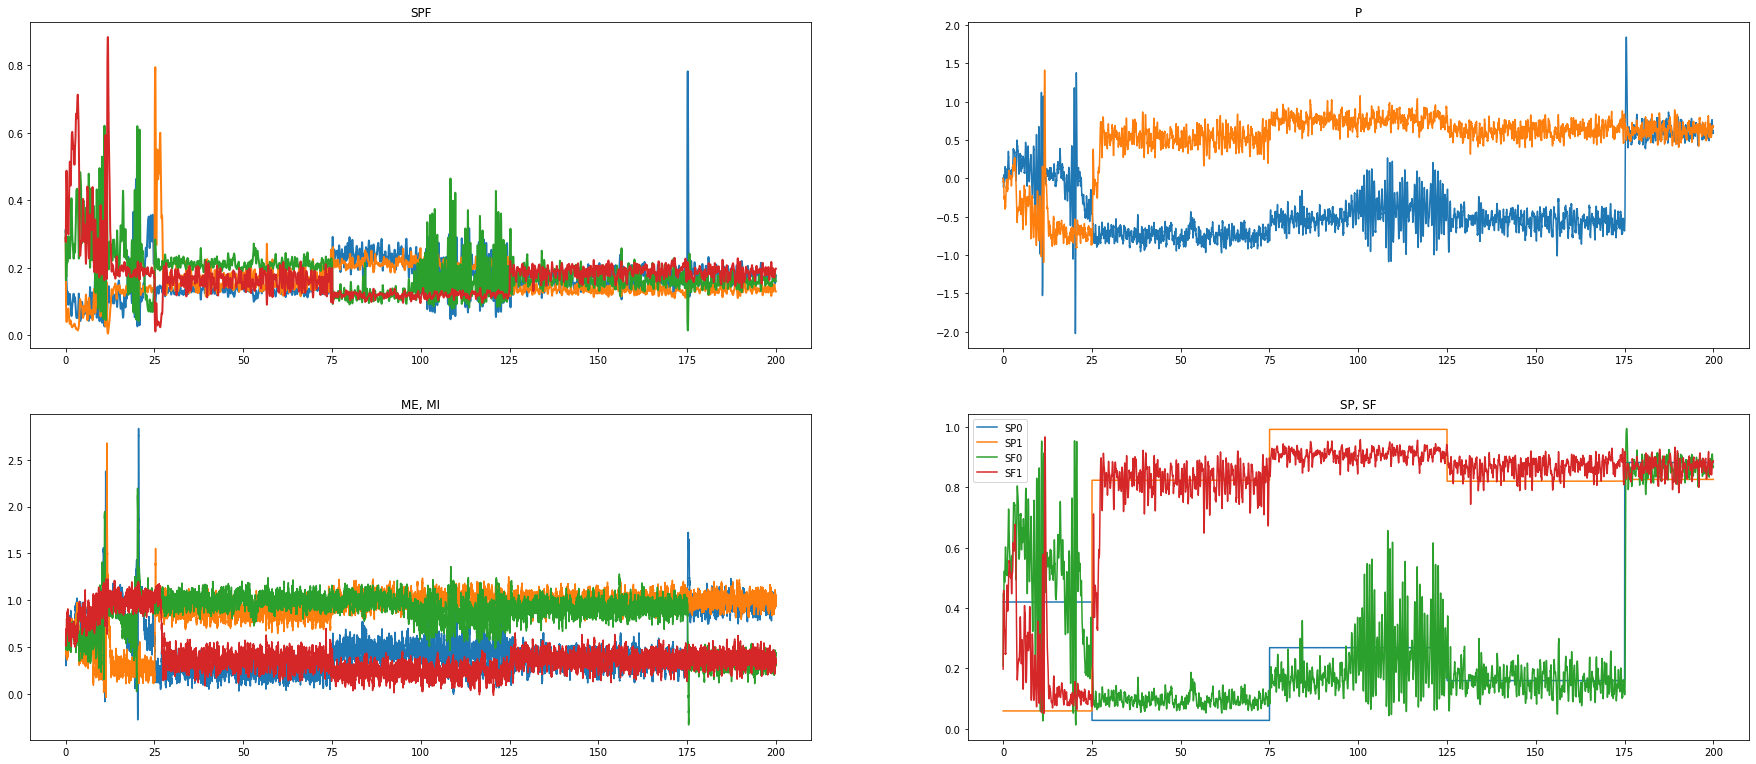

In [9]:
# state var trackers
M_track_fig = plt.figure(figsize=fs)
track_data = np.array(data[M_track])
plt.plot(times, data[M_track[0]])
plt.plot(times, data[M_track[1]])
if M_type == "am":
    plt.plot(times, data[M_track[2]])
elif M_type == "am_pm":
    plt.plot(times, data[M_track[3]])
if M_type == "am2D":
    plt.legend(['u','c'])
else:
    plt.legend(['u','c','I'])
#plt.plot(times, track_data.trose())
#plt.plot(times, data[ME[0],:],'r')
plt.title(' state vars sample')

# weight tracking
W_fig1 = plt.figure(figsize=fs)
w_track_data1 = np.array(data[SPF__M_track[0:N]])
w_track_data2 = np.array(data[SPF__M_track[N:]])
plt.plot(times, w_track_data1.transpose())
SPF__M_legends1 = ['SPF1['+str(i)+']--M' for i in range(N)]
plt.plot(times, w_track_data2.transpose())
SPF__M_legends2 = ['SPF2['+str(i)+']--M' for i in range(N)]
plt.legend(SPF__M_legends1+SPF__M_legends2)
plt.title('SPF--M weights')

# joint plot
joint_fig, axs = plt.subplots(2, 2, figsize=(2.2*fs[0], 2.2*fs[1]))
axs[0][0].plot(times, SPF_data.transpose(), linewidth=2)
axs[0][0].set_title('SPF')
P_data = np.array(data[P])
axs[0][1].plot(times, P_data.transpose())
axs[0][1].set_title('P')
axs[1][0].plot(times, ME_data.transpose())
axs[1][0].plot(times, MI_data.transpose())
axs[1][0].set_title('ME, MI')
axs[1][1].plot(times, SP_data.transpose())
axs[1][1].plot(times, SF_data.transpose())
axs[1][1].set_title('SP, SF')
axs[1][1].legend(['SP0', 'SP1', 'SF0', 'SF1'])

plt.show()

In [10]:
m_id = 0
for idx, syn in enumerate(net.syns[ME[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in GE:
        pre_pop = 'GE'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, m_id, syn.w, syn.port))

0) SPF1 (4) --> ME[0], w=1.004762, port=0
1) SPF1 (5) --> ME[0], w=0.000000, port=0
2) SPF2 (6) --> ME[0], w=0.000000, port=0
3) SPF2 (7) --> ME[0], w=0.000000, port=0
4) ME (11) --> ME[0], w=-0.010000, port=1
5) MI (12) --> ME[0], w=-0.500000, port=1


In [11]:
m_id = 0
for idx, syn in enumerate(net.syns[MI[m_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    elif pre_id in GE:
        pre_pop = 'GE'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, m_id, syn.w, syn.port))

0) SPF1 (4) --> MI[0], w=0.000000, port=0
1) SPF1 (5) --> MI[0], w=0.000000, port=0
2) SPF2 (6) --> MI[0], w=1.005275, port=0
3) SPF2 (7) --> MI[0], w=0.000000, port=0
4) MI (13) --> MI[0], w=-0.010000, port=1
5) ME (10) --> MI[0], w=-0.500000, port=1


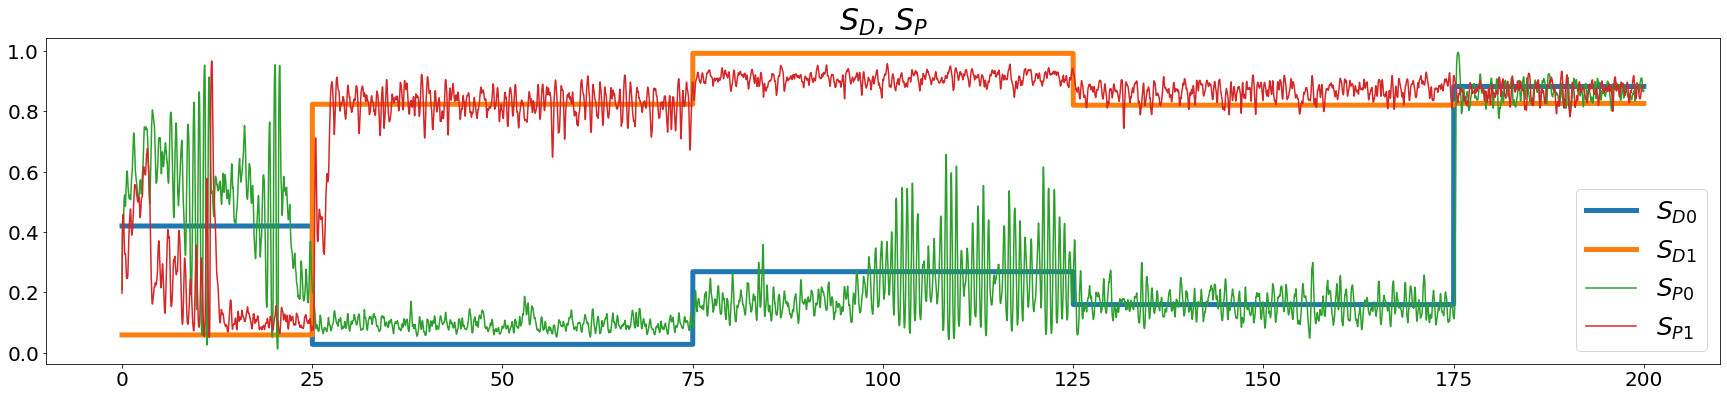

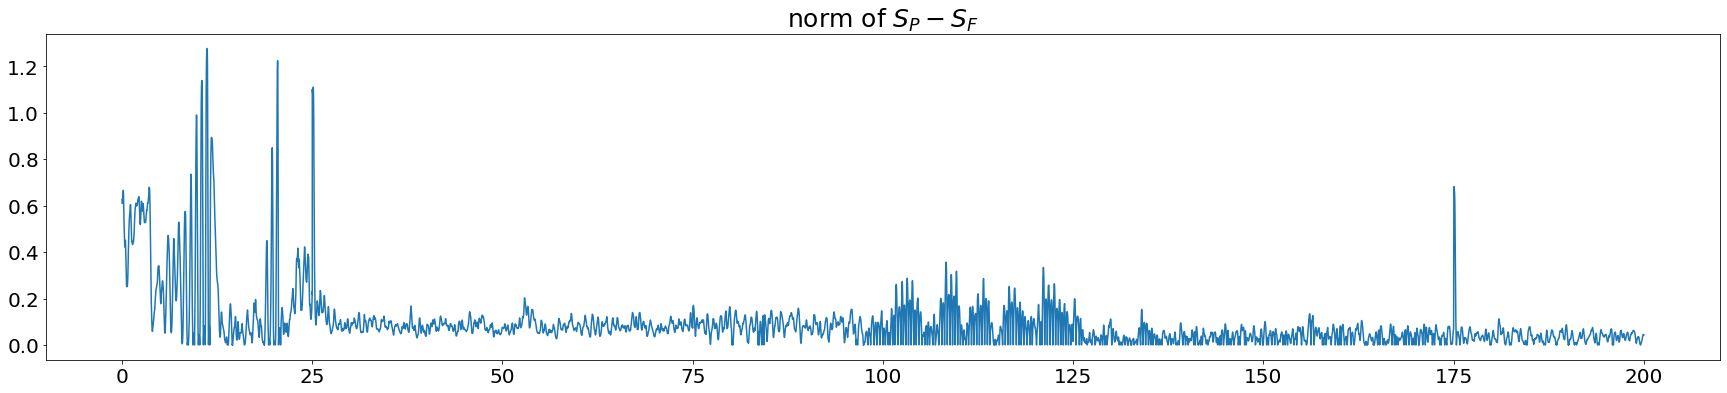

Mean of normalized S_P - SF norm: 0.094960


In [12]:
# Nicely formatted figures
figB = plt.figure(figsize=(30,6))
plt.plot(times, SP_data.transpose(), linewidth=5)
plt.plot(times, SF_data.transpose())
plt.title('$S_D$, $S_P$', fontsize=30)
plt.legend(['$S_{D0}$', '$S_{D1}$', '$S_{P0}$', '$S_{P1}$'], fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

if N > 1:
    SP_data_unit = (SP_data/np.linalg.norm(SP_data, axis=0))
    SF_data_unit = (SF_data/np.linalg.norm(SF_data, axis=0))
    SP_SF = SP_data_unit - SF_data_unit
else:
    SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
figC = plt.figure(figsize=(30,6))
plt.plot(times, SP_SF_norm)
plt.title('norm of $S_P - S_F$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

print("Mean of normalized S_P - SF norm: %f" %(np.mean(SP_SF_norm)))

In [13]:
idx1 = int(np.round(SP_SF_norm.size/2.))
print("Mean of normalized S_P - SF norm (first half): %f" %(np.mean(SP_SF_norm[:idx1])))
print("Mean of normalized S_P - SF norm (second half): %f" %(np.mean(SP_SF_norm[idx1:])))

Mean of normalized S_P - SF norm (first half): 0.133818
Mean of normalized S_P - SF norm (second half): 0.056102
